# **Insights from Failed Orders**

Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order.

In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

# **Data Description**

We have two data sets: data_orders and data_offers, both being stored in a CSV format.

The data_orders data set contains the following columns:


order_datetime - time of the order


origin_longitude - longitude of the order


origin_latitude - latitude of the order


m_order_eta - time before order arrival


order_gk - order number


order_status_key - status, an enumeration consisting of the following mapping:


4 - cancelled by client,


9 - cancelled by system, i.e., a reject


is_driver_assigned_key - whether a driver has been assigned


cancellation_time_in_seconds - how many seconds passed before cancellation


The data_offers data set is a simple map with 2 columns:

order_gk - order number, associated with the same column from the orders data set


offer_id - ID of an offer


# **Data wrangling**

In [1]:
from google.colab import files
uploaded = files.upload()

Saving data_offers.csv to data_offers.csv
Saving data_orders.csv to data_orders.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Loading data
data_orders = pd.read_csv('data_orders.csv')
data_offers = pd.read_csv('data_offers.csv')

In [29]:
# Checking number of rows and columns
data_orders.shape

(10716, 8)

In [30]:
# Checking number of rows and columns
data_offers.shape

(334363, 2)

In [31]:
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [32]:
data_offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [33]:
# Checking data type of each column
data_orders.dtypes

order_datetime                    object
origin_longitude                 float64
origin_latitude                  float64
m_order_eta                      float64
order_gk                           int64
order_status_key                   int64
is_driver_assigned_key             int64
cancellations_time_in_seconds    float64
dtype: object

In [34]:
# Checking data type of each column
data_offers.dtypes

order_gk    int64
offer_id    int64
dtype: object

In [35]:
# Checking % of na values in each column
(data_orders.isna().mean().mul(100).pipe(lambda ser: ser[ser > 0]))

m_order_eta                      73.740202
cancellations_time_in_seconds    31.812243
dtype: float64

In [36]:
# Checking % of na values in each column
(data_offers.isna().mean().mul(100).pipe(lambda ser: ser[ser > 0]))

Series([], dtype: float64)

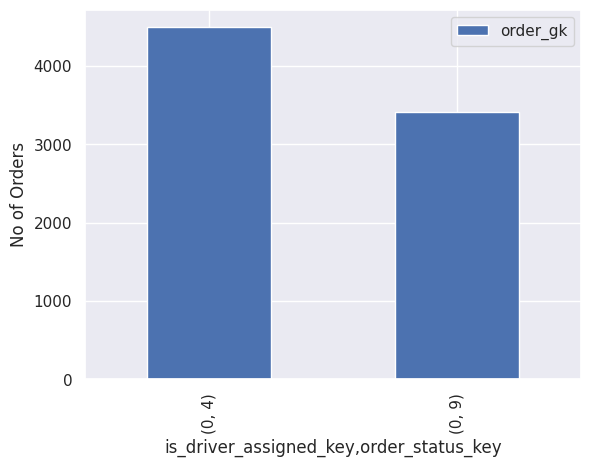

In [4]:
# Exploring why there are so many na values in m_order_eta.
# ETA is missing when there is not driver assignment.
eta = data_orders.query('m_order_eta.isna()')
eta_na = eta.groupby(['is_driver_assigned_key','order_status_key'])['order_gk'].count()
sns.set_theme(style="darkgrid")
_= eta_na.plot(kind='bar',legend=True,subplots=False, ylabel='No of Orders');
plt.show()

In [38]:
# Examining unique values is_driver_assigned_key
(data_orders.is_driver_assigned_key.value_counts())

is_driver_assigned_key
0    7902
1    2814
Name: count, dtype: int64

In [39]:
# Merging the two datasets on order_gk column
df = pd.merge(data_offers, data_orders, on="order_gk")

In [40]:
# Checking number of rows and columns
# Merging has added more rows
df.shape

(31268, 9)

In [41]:
# Noticed some duplicate orders (e.g. order_gk = 3000629332007)
# Let's avoid merging datasets since 'offer_id' column from data_offers does not add relevant information to the following tasks
df.head()

,order_gk,offer_id,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,3000629332007,300052226205,17:53:21,-1.001639,51.492854,NaN,9,0,NaN
1,3000629332007,300052226356,17:53:21,-1.001639,51.492854,NaN,9,0,NaN
2,3000629332007,300052226236,17:53:21,-1.001639,51.492854,NaN,9,0,NaN
3,3000629332007,300052226218,17:53:21,-1.001639,51.492854,NaN,9,0,NaN
4,3000630355741,300052290999,07:01:42,-0.978128,51.454907,NaN,4,0,206.0


In [42]:
# It seems that an order number (order_gk) can have many offer ids (offer_id)
(data_offers.query('order_gk == 3000629332007'))

,order_gk,offer_id
103,3000629332007,300052226205
181883,3000629332007,300052226356
218667,3000629332007,300052226236
278832,3000629332007,300052226218


In [5]:
# Creating a copy of data_orders to use it in the following tasks.
df = data_orders.copy()

In [46]:
df.shape

(10716, 8)

In [6]:
# Converting object to datetime
df['order_datetime'] = df['order_datetime'].apply(pd.to_datetime)

In [48]:
# Checking data type of each column
df.dtypes

order_datetime                   datetime64[ns]
origin_longitude                        float64
origin_latitude                         float64
m_order_eta                             float64
order_gk                                  int64
order_status_key                          int64
is_driver_assigned_key                    int64
cancellations_time_in_seconds           float64
dtype: object

In [7]:
# Renaming values for 'is_driver_assigned_key' and 'order_status_key'
df['is_driver_assigned_key'] = np.where(df['is_driver_assigned_key']==1,'Yes','No')
df['order_status_key'] = np.where(df['order_status_key']==4,'Client_Cancelled','System_Cancelled')

In [8]:
# Renaming columns
cols = {'order_datetime':'order_time',
        'origin_longitude':'longitude',
        'origin_latitude':'latitude',
        'm_order_eta':'ETA',
        'order_gk':'order_id',
        'order_status_key':'order_status',
        'is_driver_assigned_key':'is_driver_assigned',
        'cancellations_time_in_seconds':'cancellation_time'}

df.rename(columns=cols,inplace=True)

In [51]:
df.head()

,order_time,longitude,latitude,ETA,order_id,order_status,is_driver_assigned,cancellation_time
0,2024-06-28 18:08:07,-0.978916,51.456173,60.0,3000583041974,Client_Cancelled,Yes,198.0
1,2024-06-28 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client_Cancelled,No,128.0
2,2024-06-28 12:07:50,-0.969520,51.455544,477.0,3000582891479,Client_Cancelled,Yes,46.0
3,2024-06-28 13:50:20,-1.054671,51.460544,658.0,3000582941169,Client_Cancelled,Yes,62.0
4,2024-06-28 21:24:45,-0.967605,51.458236,NaN,3000583140877,System_Cancelled,No,NaN


**Task 1**


Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

In [9]:
cancellations = df.groupby(['is_driver_assigned','order_status'])['order_id'].count()
cancellations

is_driver_assigned  order_status    
No                  Client_Cancelled    4496
                    System_Cancelled    3406
Yes                 Client_Cancelled    2811
                    System_Cancelled       3
Name: order_id, dtype: int64

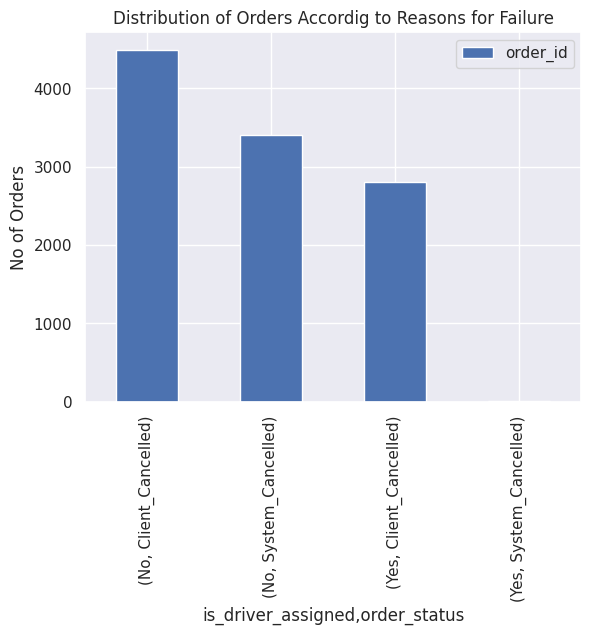

In [10]:
_= cancellations.plot(kind='bar',legend=True,subplots=False, ylabel='No of Orders', title='Distribution of Orders Accordig to Reasons for Failure');

*The highest number of cancellations were done by clients before
driver assigment. This might be due to slow driver assignment.*

*There was a high number of client cancellations even when they were assigned a driver. This might be due to the additional waiting time (ETA) on top of the already slow driver assignment.*

**Task 2**


Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

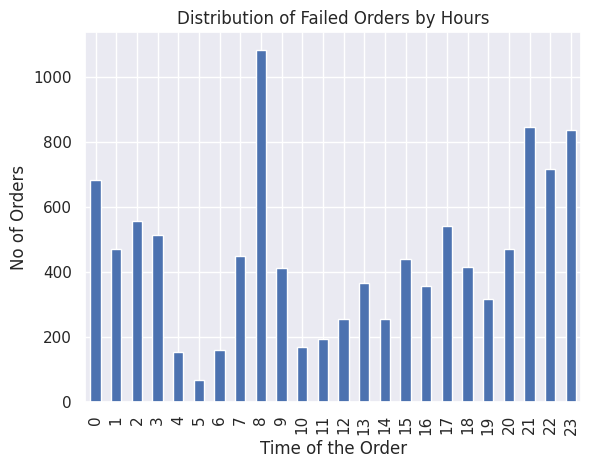

In [11]:
_= df['order_time'].groupby([df['order_time'].dt.hour]).count().plot(kind="bar", xlabel='Time of the Order', ylabel='No of Orders', title='Distribution of Failed Orders by Hours')

In [12]:
t2 = df.groupby([df['order_time'].dt.hour,'is_driver_assigned','order_status'])['order_id'].count()
t2

order_time  is_driver_assigned  order_status    
0           No                  Client_Cancelled    298
                                System_Cancelled    263
            Yes                 Client_Cancelled    120
                                System_Cancelled      2
1           No                  Client_Cancelled    219
                                                   ... 
22          No                  System_Cancelled    241
            Yes                 Client_Cancelled    149
23          No                  Client_Cancelled    378
                                System_Cancelled    302
            Yes                 Client_Cancelled    156
Name: order_id, Length: 74, dtype: int64

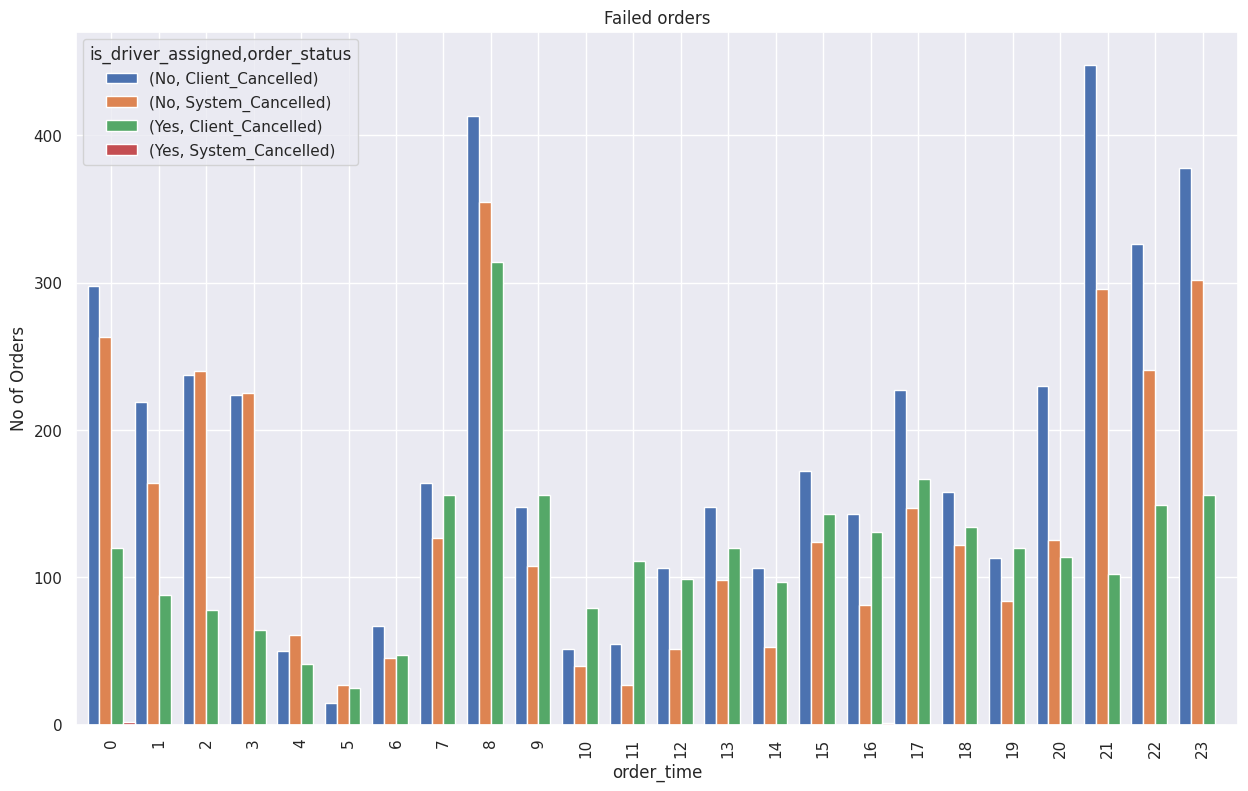

In [13]:
t2.reset_index().pivot(index='order_time', columns=['is_driver_assigned','order_status'], values = 'order_id').plot(kind='bar',xticks=range(0,24),figsize=(15,9), width=1, title='Failed orders', ylabel= 'No of Orders');

*The charts above show that the highest number of cancellations occurred at 08:00, with the majority happening before driver assignment. Client cancellations with driver assignment were high from 09:00 to 11:00.*

*This indicates that slow driver assignment has a significant impact during peak traffic times (e.g., 08:00, 17:00, 21:00)*


**Task 3**


Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [14]:
t3 = df.groupby([df['order_time'].dt.hour,'is_driver_assigned'])['cancellation_time'].mean()
t3

order_time  is_driver_assigned
0           No                    111.557047
            Yes                   293.616667
1           No                     98.132420
            Yes                   247.715909
2           No                    106.438819
            Yes                   303.307692
3           No                    104.361607
            Yes                   292.640625
4           No                     90.000000
            Yes                   243.219512
5           No                    121.800000
            Yes                   314.400000
6           No                    124.955224
            Yes                   272.553191
7           No                    112.628049
            Yes                   188.891026
8           No                    120.702179
            Yes                   189.025478
9           No                    120.000000
            Yes                   216.493590
10          No                     74.607843
            Yes         

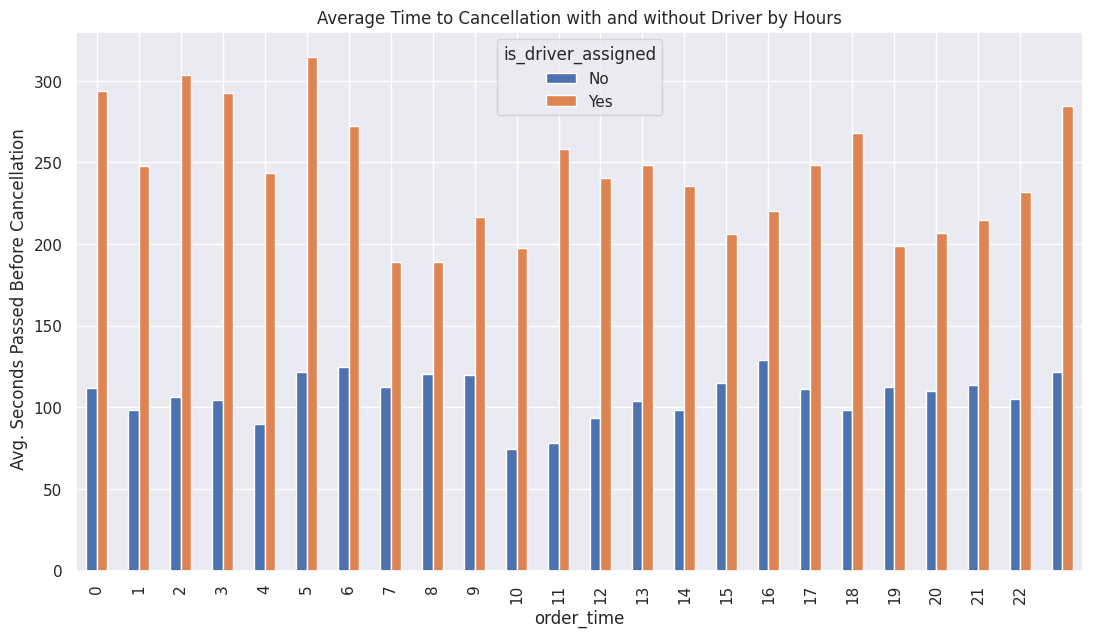

In [15]:
t3.reset_index().pivot(index='order_time', columns='is_driver_assigned', values='cancellation_time').plot(kind='bar', xticks=range(0,23), figsize=(13,7), title='Average Time to Cancellation with and without Driver by Hours', ylabel= ' Avg. Seconds Passed Before Cancellation');

In [24]:
t3

order_time  is_driver_assigned
0           No                    111.557047
            Yes                   293.616667
1           No                     98.132420
            Yes                   247.715909
2           No                    106.438819
            Yes                   303.307692
3           No                    104.361607
            Yes                   292.640625
4           No                     90.000000
            Yes                   243.219512
5           No                    121.800000
            Yes                   314.400000
6           No                    124.955224
            Yes                   272.553191
7           No                    112.628049
            Yes                   188.891026
8           No                    120.702179
            Yes                   189.025478
9           No                    120.000000
            Yes                   216.493590
10          No                     74.607843
            Yes         

*The average time to cancellation with driver assignment is significantly higher than without driver assignment for every hour. Customers cancel their orders earlier when no driver is assigned.*

<Axes: xlabel='cancellation_time', ylabel='is_driver_assigned'>

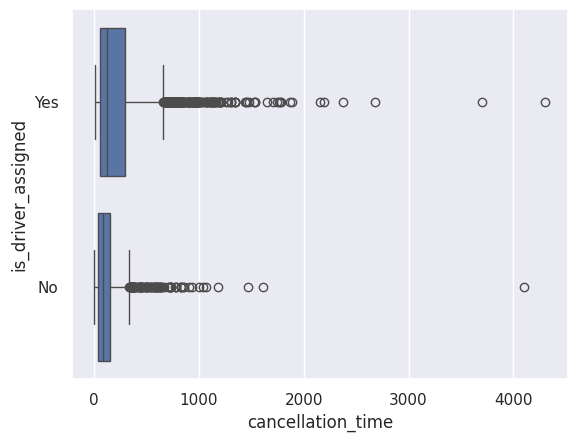

In [16]:
# Investigating outliers in 'cancellation_time' with and without driver assigment
# There is a high number of outliers with driver assignmet
sns.boxplot(x= df['cancellation_time'], y= df['is_driver_assigned'])

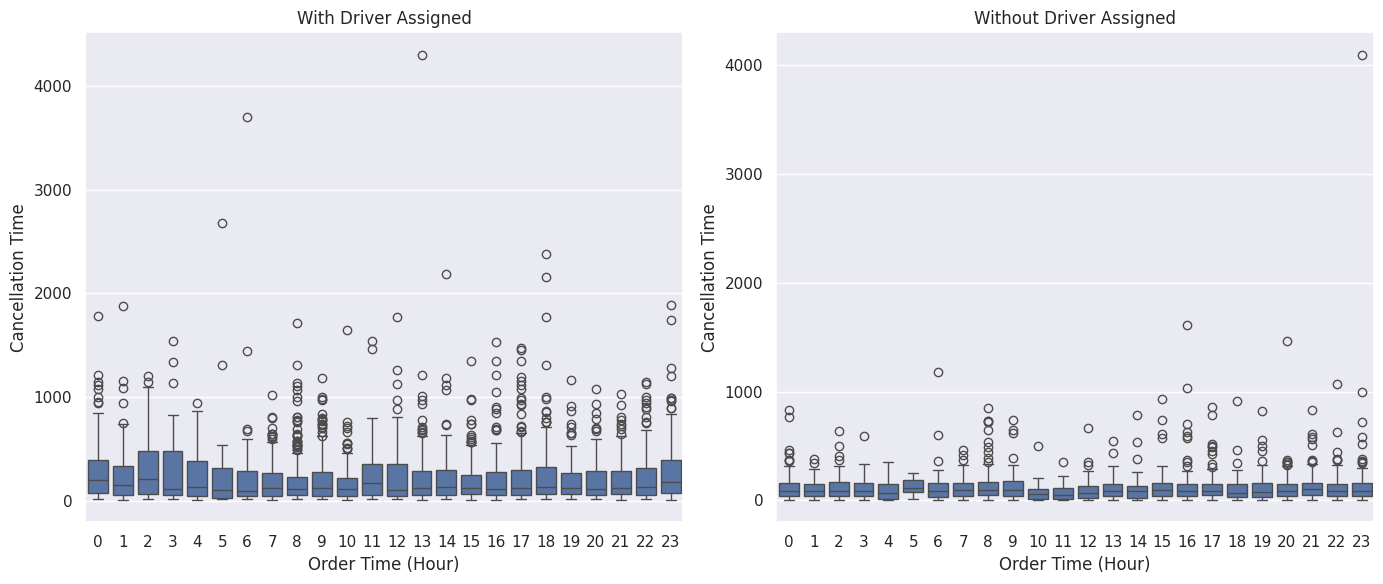

In [20]:
with_driver = df.query('is_driver_assigned == "Yes"')
without_driver = df.query('is_driver_assigned == "No"')

# Create a single figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the boxplot for orders with a driver assigned
sns.boxplot(ax=axes[0], x=with_driver['order_time'].dt.hour, y=with_driver['cancellation_time'])
axes[0].set_title('With Driver Assigned')
axes[0].set_xlabel('Order Time (Hour)')
axes[0].set_ylabel('Cancellation Time')

# Plot the boxplot for orders without a driver assigned
sns.boxplot(ax=axes[1], x=without_driver['order_time'].dt.hour, y=without_driver['cancellation_time'])
axes[1].set_title('Without Driver Assigned')
axes[1].set_xlabel('Order Time (Hour)')
axes[1].set_ylabel('Cancellation Time')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Removing high outliers using IQR
def remove_high_outliers_iqr(df, col):
    ser = df[col]
    iqr = ser.quantile(.75) - ser.quantile(.25)
    upper_bound = ser.quantile(.75) + 1.5 * iqr
    large_mask = ser <= upper_bound
    return large_mask

t3_iqr = df[remove_high_outliers_iqr(df, 'cancellation_time')]

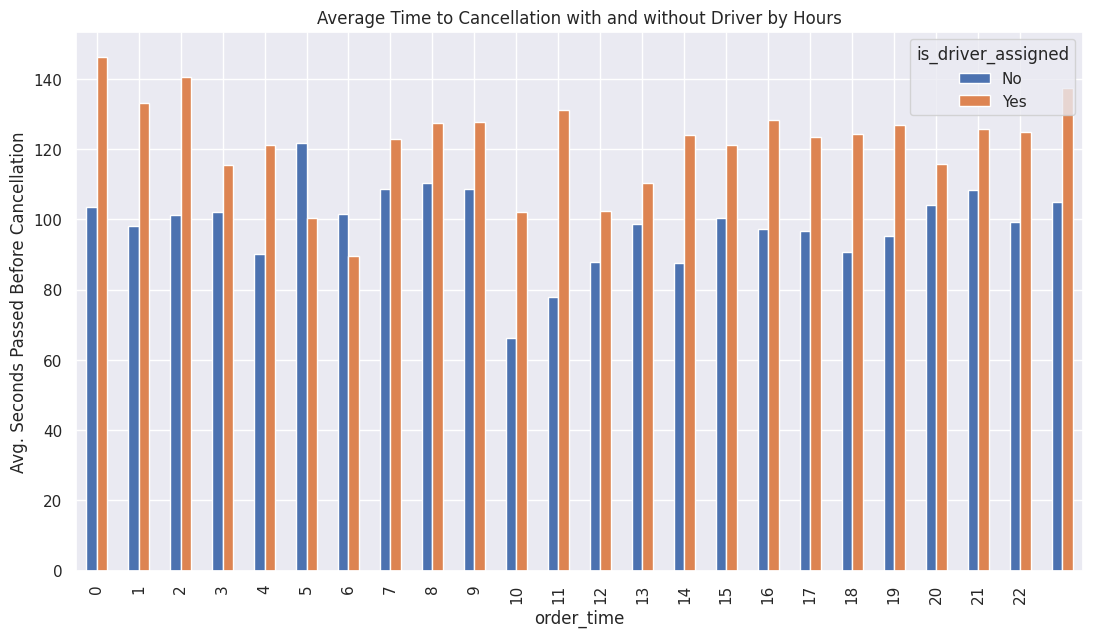

In [26]:
t3_p2 = t3_iqr.groupby([df['order_time'].dt.hour,'is_driver_assigned'])['cancellation_time'].mean()
t3_p2.reset_index().pivot(index='order_time', columns='is_driver_assigned', values='cancellation_time').plot(kind='bar', xticks=range(0,23), figsize=(13,7), title='Average Time to Cancellation with and without Driver by Hours', ylabel= 'Avg. Seconds Passed Before Cancellation');


*After removing outliers, it can be seen that the average time to cancellation with a driver is still higher than without a driver for every hour except from 05:00 to 06:00. Bear in mind that approximately 30% of the cancellation times are missing.*

**Task 4**


Plot the distribution of average ETA by hours. How can this plot be explained?


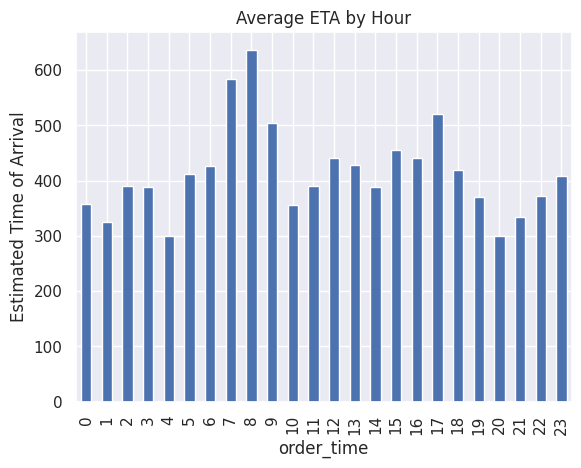

In [30]:
_ = df['ETA'].groupby([df['order_time'].dt.hour]).mean().plot(kind="bar", ylabel='Estimated Time of Arrival',
                     title="Average ETA by Hour")

The highest average ETA is at 08:00. This might explain the high number of client cancellations that occured at 08:00.